In [1]:
import numpy as np
import pandas as pd
import os, time, logging
from src.data import Hicmat, HiCDataset, plot_data, load_hic_groundtruth, preprocess_data
from src.tad_algo import TopDom, TADtree, OnTAD, TADbit
from src.metrics import compare_to_groundtruth
from src.consensus import BordersConsensus
from src.utils import *

## BananaTADS - Classic usage
Give the path to data folder, the path to the file containing the raw data (without extension), the cell_type and the resolution

In [2]:
folder = os.path.join('data', 'example')
data_path = os.path.join(folder, 'chr1_100kb') + '.npy' # Important: use .npy extension - if you don't want to repreprocess the data
cell_type = 'GM12878' # Can be skipped if it's clearly specified in the folder path
chr = '1' # Can be skipped if it comes from standard HiC data
resolution = 100000

In [3]:
# If files weren't preprocessed, do it now
if not os.path.isfile(data_path):
    preprocess_data(folder, resolution)

Create the Hicmat instance, and plot data

In [4]:
hic_mat = Hicmat(data_path, resolution, auto_filtering=True, cell_type=cell_type)

d:\Programmation\Meet-EU\src\data.py:59: RuntimeWarning: divide by zero encountered in log10
  m = np.log10(m)


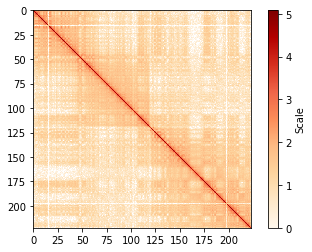

In [5]:
plot_data(hic_mat.reduced_matrix, resolution)

Run TopDom on the HiC data

In [6]:
topdom = TopDom()
topdom_tads = topdom.getTADs(hic_mat, window=2)

TopDom Step 1 : Generating binSignals by computing bin-level contact frequencies
TopDom Step 2 : Detect TD boundaries based on binSignals
TopDom Step 3 : Statistical Filtering of false positive TD boundaries
TopDom : Exporting TADs


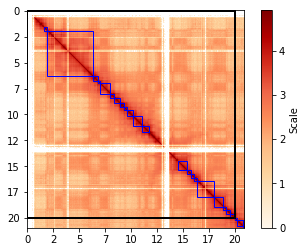

In [7]:
# Plot TopDom TADs on the region 0Mb -> 20Mb
plot_data(hic_mat.original_matrix, resolution, region=(0,20000000), tads=topdom_tads)

Load expected TADs (from Arrowhead results) for our file and compare our predicted TADs with ground truth

In [8]:
gt_folder = os.path.join('data', 'TADs')
_, arrowhead_tads = load_hic_groundtruth(data_path, resolution, arrowhead_folder=gt_folder, cell_type=cell_type, chr=chr)
_, _, gt_rate_topdom, pred_rate_topdom = compare_to_groundtruth(ground_truth=arrowhead_tads, predicted_tads=topdom_tads, gap=200000)
print('TopDom:')
print('\tRate of ground truth correctly predicted by TopDom: ', gt_rate_topdom)
print('\tRate of TopDom\'s predicted TADs present in ground truth: ', pred_rate_topdom)

TopDom:
	Rate of ground truth correctly predicted by TopDom:  0.19122609673790777
	Rate of TopDom's predicted TADs present in ground truth:  0.39296187683284456


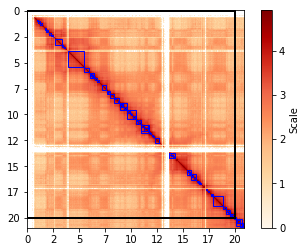

In [9]:
# Plot Arrowhead TADs on the region 0Mb -> 20Mb
plot_data(hic_mat.original_matrix, resolution, region=(0,20000000), tads=arrowhead_tads)

Create instance of our BordersConsensus TAD caller, and run it on the HiC data

N.B : With init=True, the class is automatically initialising the algorithms scores - if set to True without previously downloaded/computed "saves/ctcf_scores.json" and "saves/metrics_scores.json", it will raise an Error. Please launch evaluate_algorithm_score(), which require heavy computation while the consensus is fitting

In [10]:
consensus_method = BordersConsensus(init=True)
# consensus_method.evaluate_algorithm_score(development_set)
final_tads = consensus_method.get_consensus_tads(hic_mat=hic_mat, threshold=10) # TADs '(from, to)'
final_tads_scores = consensus_method.get_consensus(hic_mat=hic_mat, threshold=10) # TADs scores '(from, to):score'

Compare BordersConsensus's TADs with expected TADs (from Arrowhead results)

In [ ]:

_, _, gt_rate_final, pred_rate_final = compare_to_groundtruth(ground_truth=arrowhead_tads, predicted_tads=final_tads, gap=200000)
print('Final consensus:')
print('\tRate of ground truth correctly predicted by final consensus: ', gt_rate_final)
print('\tRate of final consensus\'s predicted TADs present in ground truth: ', pred_rate_final)

c:\Users\llego\MEET-U\Team-SA1\src\data.py:59: RuntimeWarning: divide by zero encountered in log10
  m = np.log10(m)


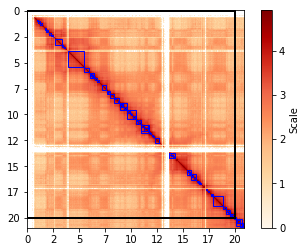

In [ ]:
# Plot BordersConsensus TADs on the region 0Mb -> 20Mb
plot_data(hic_mat.original_matrix, resolution, region=(0,20000000), tads=final_tads)